In [1]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ergodicpy as ep
from ergodicpy.plots import combine_legends
from functools import cached_property

In [58]:
def rand(i, x, y):
    "When dealing with many ensembles, randomise the difference in those ensembles"
    return np.random.uniform(x, y)

def mod(i, x, y, n=2):
    "When only 2 ensembles, convient to specify a garanteed distance"
    return x if i % n else y

class ChiScan:
    def __init__(self, func, variable_range, fixed=None, lazy=False,
                obs=1000, ensembles=2, trials=100, bins=10, cp=None):
        self.func = func
        self.variable_range = variable_range
        self.fixed = variable_range[0] if fixed is None else fixed
        self.obs = obs
        self.ensembles = ensembles
        self.trials = trials
        self.bins = bins
        self.cp = cp
        
        if not lazy:
            self.generate()
            self.analyse()
        
    def generate(self):
        """ Generates the observations """
        observations = {}
        s = mod if self.ensembles == 2 else rand
        for v in self.variable_range:
            observations[v] = []
            if self.cp: self.cp("generating", v)
            for t in range(self.trials):
                observations[v].append([
                    self.func(e, self.fixed, v, self.obs, s)
                        for e in range(self.ensembles)])
        self.observations = observations
    
    def analyse(self, count=None):
        """ Creates ErgodicEnsembles and stores results """
        self.ees = {}
        self.results = []
        for v, trials in self.observations.items():
            if self.cp: self.cp("analysing", v)
            self.ees[v] = []
            for trial in trials:
                if count is None:
                    count = self.bins
                bins = ep.bino(trial, count)
                # ensemble
                ee = ep.ErgodicEnsemble(trial, bins)
                # chi2
                chi2, p, dof, expected = ee.chi2()
                cex = ce2x(ee.complexity)
                #cex2 = ce2x(ee.complexity**2, m=)
                
                self.results.append({
                    'ce': ee.complexity,
                    'cex': cex,
                    'ce^2': ee.complexity**2,
                    #'cex2': cex2,
                    'p': p,
                    'chi^2': chi2,
                    'obs': self.obs,
                    'v': v,
                    #'pcex': 1 - stats.chi2.cdf(cex, dof),
                    #'pcex2': 1 - stats.chi2.cdf(cex2, dof)
                })
                self.ees[v].append(ee)
        if self.cp: self.cp("")
    
    def dataframe(self, notnull=True):
        df = pd.DataFrame([r for r in self.results])
        return df[pd.notnull(df['chi^2'])] if notnull else df
    
    @cached_property
    def df(self):
        return self.dataframe()
    
    def lineplot(self, y, label, ax=None, var=False, color=None, x='v'):
        df = self.dataframe()
        if not var:
            df = df.groupby('v').mean().reset_index()
        return sns.lineplot(data=df, x=x, y=y, label=label, ax=ax, color=color)
    
    def plot(self, y='ce'):
        """ Plots ergodic complexity, chi2 and p-value against the variety of spreads """
        df = self.dataframe()
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        
        # plot complexity left graph
        g = sns.lineplot(data=df, x='v',y=y, ax=axes[0], color='mediumpurple', label=y)
        
        # chi2 on left graph, right axis
        ax02 = axes[0].twinx()
        sns.lineplot(data=df, x='v', y='chi^2', ax=ax02, color='forestgreen', label='chi^2')
        
        # p's on the right
        ax12 = axes[1]
        sns.lineplot(data=df, x='v',y='p', ax=ax12, color='darkcyan', label='chi p-value')
        #sns.lineplot(data=df, x='v',y='pcex', ax=ax12, label='p(c)')
        #sns.lineplot(data=df, x='v',y='p(c^2)', ax=ax12, label='p(c^2)')
        
        ax12.axhline(y=0.05, color='grey', linestyle='dashed')
        ax12.axhline(y=0.1, color='grey', linestyle='dotted')
        
        # meta
        g.set_title("%s obs, %s bins, %s trials" % (self.obs, self.bins, self.trials))
        combine_legends(axes[0], ax02)
        #combine_legends(axes[1], ax12)
        #return fig
    
    def regress_curve(self, curve=1.0):
        df = self.dataframe(True)
        return self.regression(df['chi^2'], df['ce']**curve)
    
    def regression(self, x, y):
        from sklearn.linear_model import LinearRegression
        m = LinearRegression().fit(x.to_numpy().reshape(-1,1), y)
        return (m.coef_, m.intercept_)
    
    def correlate(self, curve=2.0, regress=True):
        """ Plots complexity against chi2 directly """
        fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
        df = self.dataframe()
        
        # basic relationship plot
        g = sns.scatterplot(data=df, y='ce', x='chi^2', hue='v', ax=axes[0])
        
        # linearise the relationship
        key = 'ce^%s' % curve
        df[key] = df['ce']**curve
        sns.scatterplot(data=df, y=key, x='chi^2', hue='v', ax=axes[1])
        
        # add regression
        if regress:
            x = df['chi^2']
            m, c = self.regression(x, df[key])
            sns.lineplot(x=x, y=m*x+c, color='cyan', ax=axes[1])


In [3]:
def regression(x, y):
    from sklearn.linear_model import LinearRegression
    x = np.array(x).reshape(-1,1)
    y = np.array(y)
    m = LinearRegression().fit(x, y)
    return (m.coef_, m.intercept_, m.score(x, y))

In [4]:
def ce2x(ce, m = 0.00034939, c = np.pi):#0.00040071679435628536):
    return (ce/m)+c

In [5]:
power = lambda i,f,v,o,s: np.random.power(s(i,f,v),o)

# Todo

- Is C_e invariant to ensembles?
- Is C_e invariant to bins? If not what is the relationship?
- Is C_e / Chi2 invariant under different relationships? (regressions)

- What is the variance of C_e & Chi2?

# Invariance to ensembles

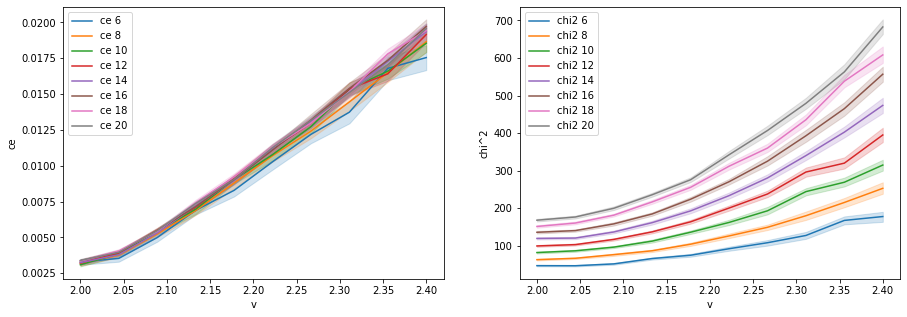

In [12]:
ensemble_scans = {}
fig, axes = plt.subplots(1, 2, figsize=(15,5))
for i in range(6,22,2):
    nbsetup.cp(i)
    escan = ChiScan(power, np.linspace(2,2.4,10), trials=100, obs=10000, ensembles=i, cp=nbsetup.cp)
    escan.lineplot('ce', 'ce %s' % i, axes[0])
    escan.lineplot('chi^2', 'chi2 %s' % i, axes[1])
    ensemble_scans[i] = escan

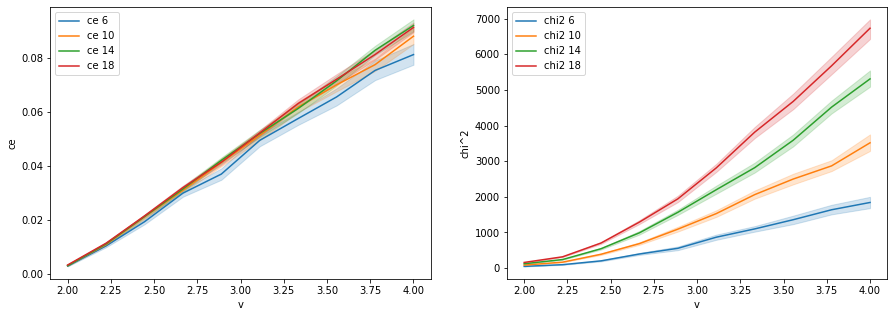

In [13]:
ensemble_scans = {}
fig, axes = plt.subplots(1, 2, figsize=(15,5))
for i in range(6,22,4):
    nbsetup.cp(i)
    escan = ChiScan(power, np.linspace(2,4,10), trials=100, obs=10000, ensembles=i, cp=nbsetup.cp)
    escan.lineplot('ce', 'ce %s' % i, axes[0])
    escan.lineplot('chi^2', 'chi2 %s' % i, axes[1])
    ensemble_scans[i] = escan

# Invariance to observations

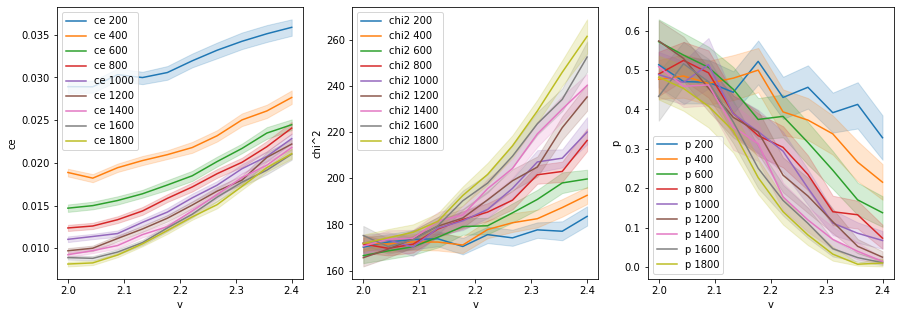

In [53]:
ob_scans = {}
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i in range(200,2000,200):
    nbsetup.cp(i)
    escan = ChiScan(power, np.linspace(2,2.4,10), trials=100, obs=i, ensembles=20, cp=nbsetup.cp)
    escan.lineplot('ce', 'ce %s' % i, axes[0])
    escan.lineplot('chi^2', 'chi2 %s' % i, axes[1])
    escan.lineplot('p', 'p %s' % i, axes[2])
    ob_scans[i] = escan

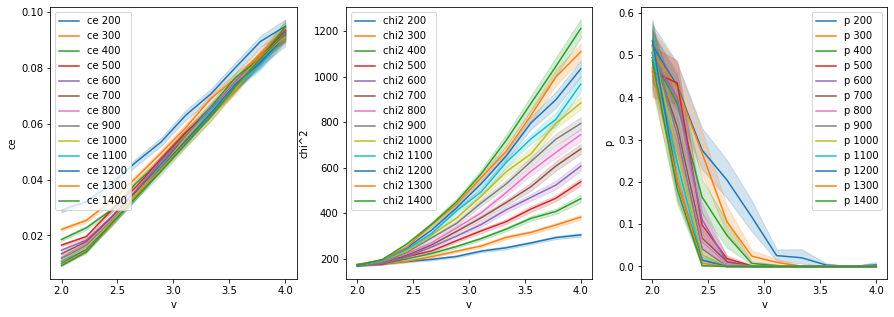

In [54]:
ob_scans = {}
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i in range(200,1500,100):
    nbsetup.cp(i)
    escan = ChiScan(power, np.linspace(2,4,10), trials=100, obs=i, ensembles=20)
    escan.lineplot('ce', 'ce %s' % i, axes[0])
    escan.lineplot('chi^2', 'chi2 %s' % i, axes[1])
    escan.lineplot('p', 'p %s' % i, axes[2])
    ob_scans[i] = escan

- Chi2 is optimistic meaning the fewer the observations, the more it thinks that the system is homogenious (when it's not).
- C_e is pesimistic, meaning the fewer the observations, the more it assumes it's complex and not homogenious.
- Worse, with Chi2 this effect gets worse the higher the heterogenity. Meaning highly heterogenious systems, but with fewer observations (still way above the recommended obs level) it gives you a false sense of confidence
- With C_e, for more observations the value is largely invariant!

# Invariance to states

20


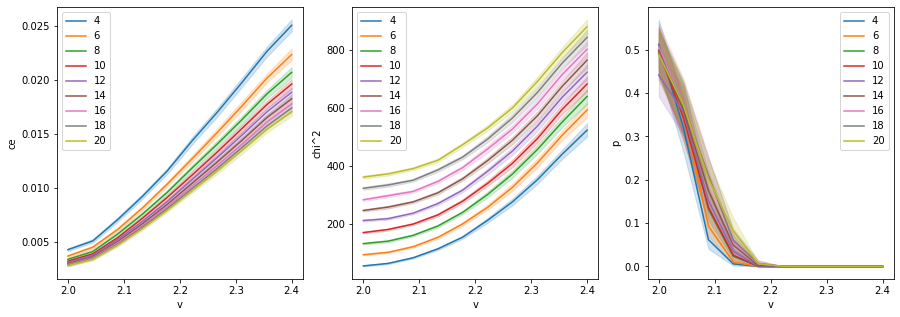

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
bin_scan = ChiScan(power, np.linspace(2,2.4,10), trials=100, obs=10000, ensembles=20, bins=i, lazy=True)
bin_scan.generate()
bin_range = range(4,22,2)
for i in bin_range:
    nbsetup.cp(i)
    bin_scan.analyse(i)
    bin_scan.lineplot('ce', i, axes[0])
    bin_scan.lineplot('chi^2', i, axes[1])
    bin_scan.lineplot('p', i, axes[2])

<AxesSubplot:>

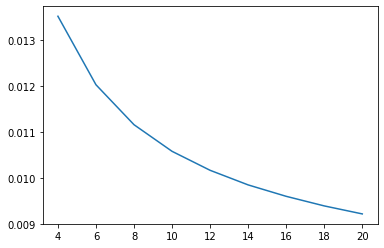

In [21]:
ces = []
for i in bin_range:
    bin_scan.analyse(i)
    ces.append(bin_scan.dataframe().mean()['ce'])

<AxesSubplot:>

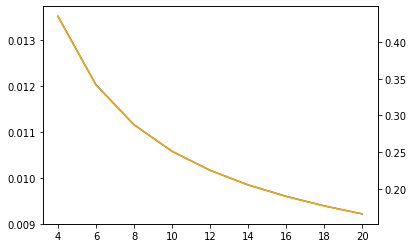

In [33]:
g = sns.lineplot(x=bin_range, y=ces)
sns.lineplot(x=bin_range, y=[1/(b)**0.6 for b in bin_range], ax=g.twinx(), color='orange')

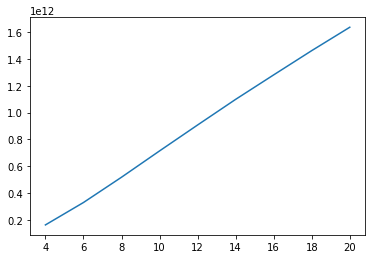

In [87]:
g = sns.lineplot(x=bin_range, y=[1/c**(6) for c in ces])

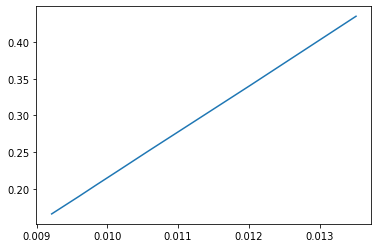

In [76]:
g = sns.lineplot(x=ces, y=[1/b**0.6 for b in bin_range])
#sns.lineplot(x=bin_range, y=[1/(b)**0.6 for b in bin_range], ax=g.twinx(), color='orange')

In [178]:
def find_power(ces, bin_range, initial_from, initial_to, steps=100, depth=5, iteration=0):
    r2s = []
    index = {}
    for i in np.linspace(initial_from, initial_to, steps):
        m, c, r2 = regression(np.array(ces), np.array([1/b**i for b in bin_range]))
        r2s.append(r2)
        index[r2] = i
    
    r2s = np.array(r2s)
    mx = np.where(r2s==r2s.max())[0][0]
    
    output = index[r2s[mx]]
    print(output, mx, iteration)
    if iteration < depth:
        output = find_power(ces, bin_range, index[r2s[mx-1]], index[r2s[mx+1]], iteration=iteration+1)
    return output

def find_regression(ces, bin_range, *args, **kwargs):
    power = find_power(ces, bin_range, *args, **kwargs)
    m, c, r2 = regression(np.array(ces), np.array([1/b**power for b in bin_range]))
    return m, c, power, r2

In [180]:
m, c, pb, r2 = find_regression(ces, bin_range, initial_from=0.58, initial_to=0.6)

0.5973737373737373 86 0
0.5973063973063972 33 1
0.5973082524046711 72 2
0.5973082965439341 50 3
0.5973082965439341 97 4
0.5973082965439341 2 5


In [181]:
m, c, pb, r2

(array([62.67781075]),
 -0.4103919928864106,
 0.5973082965439341,
 0.99999546192274)

In [ ]:
ces = m(1/b^)+c

In [185]:
bin_scan = ChiScan(power, np.linspace(4,4.8,10), trials=100, obs=10000, ensembles=20, lazy=True)
bin_scan.generate()
bin_range = range(2,22,2)
ces = []
for i in bin_range:
    nbsetup.cp(i)
    bin_scan.analyse(i)
    ces.append(bin_scan.dataframe().mean()['ce'])

points = find_regression(ces, bin_range, 0.5, 0.6)
points

20
0.6 99 0


IndexError: index 100 is out of bounds for axis 0 with size 100

In [186]:
find_regression(ces, bin_range, 0.5, 0.8)

0.6636363636363637 54 0
0.6640955004591369 57 1
0.6641060126826887 58 2
0.6641060251749329 49 3
0.6641060251749329 6 4
0.6641060251749329 1 5


(array([32.5202661]),
 -0.3309032357274205,
 0.6641060251749329,
 0.9999953285838101)

140


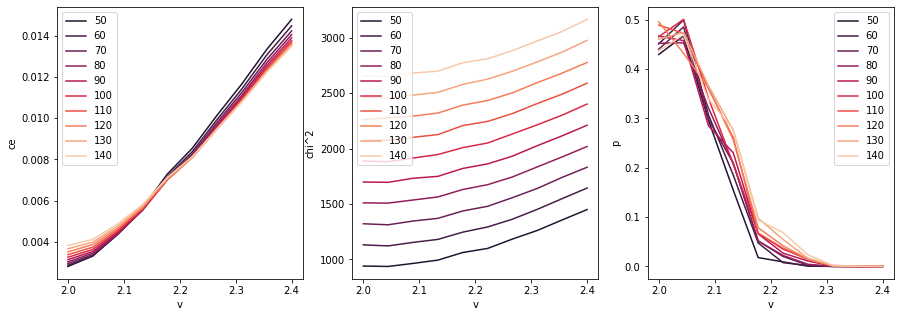

In [210]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
bin_scan = ChiScan(power, np.linspace(2,2.4,10), trials=100, obs=10000, ensembles=20, lazy=True)
bin_scan.generate()
bin_range = xf
palette = sns.color_palette("rocket", len(bin_range))
for n, i in enumerate(bin_range):
    nbsetup.cp(i)
    bin_scan.analyse(i)
    bin_scan.lineplot('ce', i, axes[0], color=palette[n])
    bin_scan.lineplot('chi^2', i, axes[1], color=palette[n])
    bin_scan.lineplot('p', i, axes[2], color=palette[n])

- with more bins early on, over the tipping point, it finds complexity where there is none because there are too few observations per bin
- with fewer bins later on, it finds complexity higher because course graining amplifies the differences

In [246]:
np.unique([int(i) for i in np.geomspace(5,200,20)])

array([  5,   6,   7,   8,  10,  13,  16,  19,  23,  28,  34,  42,  51,
        62,  75,  91, 111, 135, 164, 200])

40


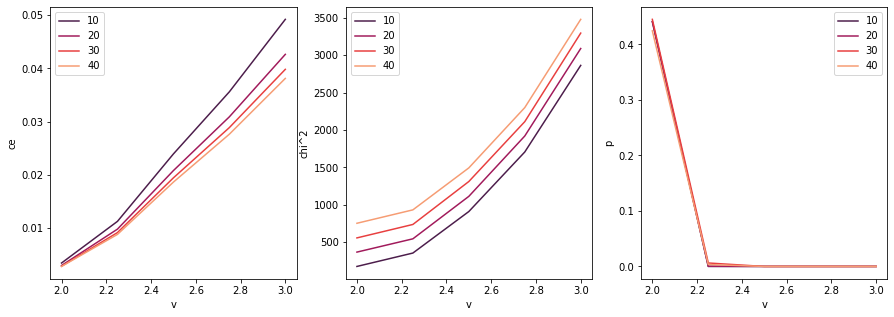

In [262]:
bin_scan = ChiScan(power, np.linspace(2,3,5), trials=20, obs=10000, ensembles=20, lazy=True)
bin_scan.generate()
fig, axes = plt.subplots(1, 3, figsize=(15,5))
bin_range = range(10,50,10)#np.unique([int(i) for i in np.geomspace(5,200,20)])
palette = sns.color_palette("rocket", len(bin_range))
for i, b in enumerate(bin_range):
    nbsetup.cp(b)
    bin_scan.analyse(b)
    bin_scan.lineplot('ce', b, axes[0], color=palette[i])
    bin_scan.lineplot('chi^2', b, axes[1], color=palette[i])
    bin_scan.lineplot('p', b, axes[2], color=palette[i])

In [61]:
def scan_bins(func, v_range=np.linspace(2,2.2,5), bin_range=range(10,50,10), bin_scan=None):
    # generate
    if bin_scan is None:
        bin_scan = ChiScan(func, v_range, trials=10, obs=10000, ensembles=20, lazy=True)
        bin_scan.generate()
    
    # analyse and plot
    fig, axes = plt.subplots(1, 4, figsize=(15,5))
    palette = sns.color_palette("rocket", len(bin_range))
    for i, b in enumerate(bin_range):
        nbsetup.cp(b)
        bin_scan.analyse(b)
        bin_scan.lineplot('ce', b, axes[0], color=palette[i])
        bin_scan.lineplot('chi^2', b, axes[1], color=palette[i])
        bin_scan.lineplot('p', b, axes[2], color=palette[i])
        bin_scan.lineplot('ce', b, axes[3], color=palette[i], x='chi^2')
    return bin_scan

40


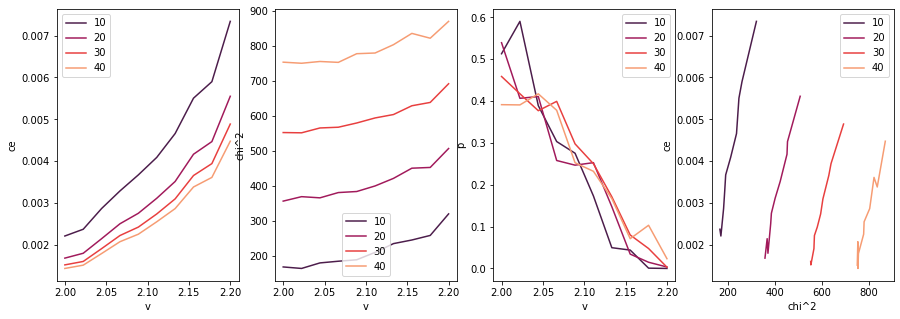

In [63]:
pwr = scan_bins(power, v_range=np.linspace(2,2.2,10))#,bin_scan=pwr)

40


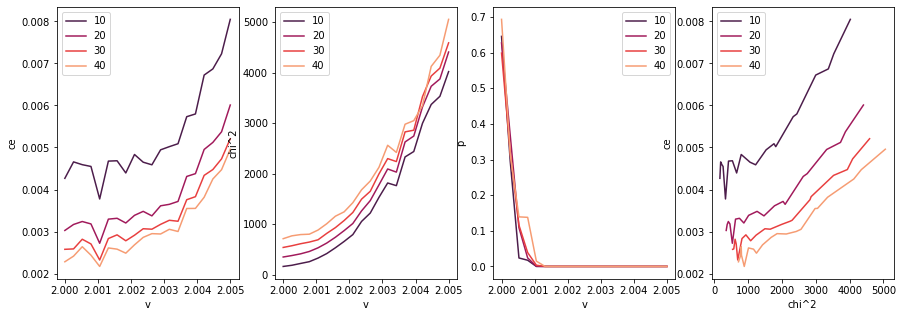

In [64]:
normal001 = lambda i,f,v,o,s: np.random.normal(s(i, f, v),0.01,o)
nrm1 = scan_bins(normal001, v_range=np.linspace(2,2.005,20))#, bin_scan=nrm1)

40


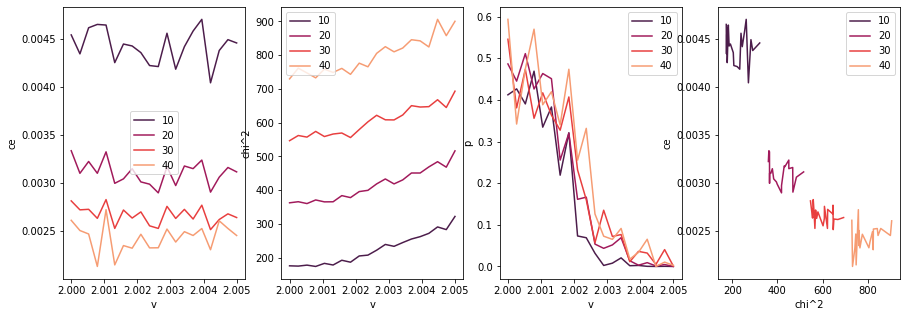

In [65]:
normal005 = lambda i,f,v,o,s: np.random.normal(s(i, f, v),0.05,o)
nrm5 = scan_bins(normal005, v_range=np.linspace(2,2.005,20))#, bin_scan=nrm5)

40


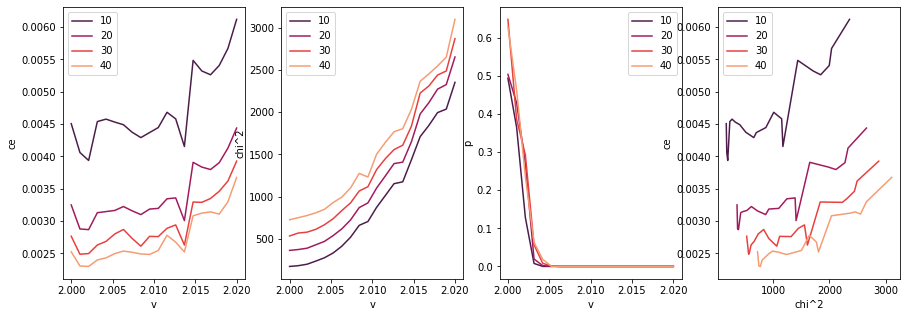

In [67]:
normal005 = lambda i,f,v,o,s: np.random.normal(s(i, f, v),0.05,o)
nrm5 = scan_bins(normal005, v_range=np.linspace(2,2.02,20))#, bin_scan=nrm5)

In [ ]:
normal005 = lambda i,f,v,o,s: np.random.normal(s(i, f, v),0.05,o)
nrm5 = scan_bins(normal005, v_range=np.linspace(2,2.02,20))#, bin_scan=nrm5)

In [34]:
pwr.dataframe().groupby('v').mean()

,ce,cex,ce^2,p,chi^2,obs
v,,,,,,
2.000000,0.001499,7.432175,0.000002,0.526349,736.327532,10000
2.022222,0.001536,7.538501,0.000002,0.489893,741.710295,10000
2.044444,0.001719,8.062726,0.000003,0.485963,742.863007,10000
2.066667,0.002049,9.005687,0.000004,0.334116,764.832638,10000
2.088889,0.002384,9.964481,0.000006,0.369935,758.173775,10000
2.111111,0.002705,10.883239,0.000007,0.290698,771.303485,10000
2.133333,0.002978,11.664882,0.000009,0.191557,792.367457,10000
2.155556,0.003512,13.193902,0.000013,0.046187,836.453493,10000
2.177778,0.003849,14.156865,0.000015,0.023018,863.223426,10000


In [35]:
nrm.dataframe().groupby('v').mean()

,ce,cex,ce^2,p,chi^2,obs
v,,,,,,
2.000000,0.002230,9.525040,0.000005,4.727538e-01,744.317551,10000
2.008889,0.002520,10.353032,0.000006,1.006876e-08,1188.013610,10000
2.017778,0.003381,12.818271,0.000012,4.307474e-95,2655.671406,10000
2.026667,0.005232,18.117427,0.000028,0.000000e+00,5458.975000,10000
2.035556,0.007287,23.996664,0.000055,0.000000e+00,8107.479895,10000
2.044444,0.010792,34.028692,0.000120,0.000000e+00,12297.622369,10000
2.053333,0.016243,49.632289,0.000278,0.000000e+00,18599.028212,10000
2.062222,0.020441,61.645490,0.000437,0.000000e+00,23484.583324,10000
2.071111,0.025450,75.982233,0.000665,0.000000e+00,29445.205295,10000


40


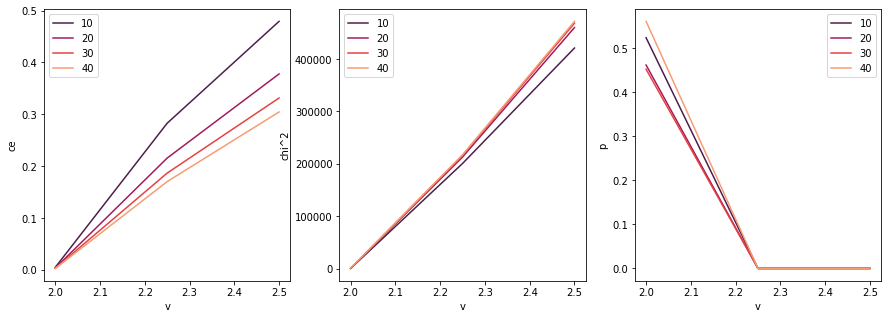

In [7]:
normal005 = lambda i,f,v,o,s: np.random.normal(s(i, f, v),0.05,o)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
bin_scan = ChiScan(normal005, np.linspace(2,2.5,3), trials=20, obs=10000, ensembles=20, lazy=True)
bin_scan.generate()
bin_range = range(10,50,10)
palette = sns.color_palette("rocket", len(bin_range))
for n, i in enumerate(bin_range):
    nbsetup.cp(i)
    bin_scan.analyse(i)
    bin_scan.lineplot('ce', i, axes[0], color=palette[n])
    bin_scan.lineplot('chi^2', i, axes[1], color=palette[n])
    bin_scan.lineplot('p', i, axes[2], color=palette[n])

40


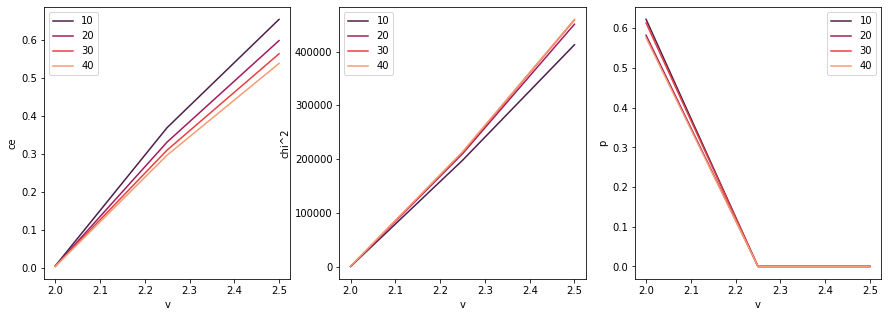

In [257]:
normal05 = lambda i,f,v,o,s: np.random.normal(s(i, f, v),0.5,o)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
bin_scan = ChiScan(normal005, np.linspace(2,2.5,3), trials=20, obs=10000, ensembles=20, lazy=True)
bin_scan.generate()
bin_range = range(10,50,10)
palette = sns.color_palette("rocket", len(bin_range))
for n, i in enumerate(bin_range):
    nbsetup.cp(i)
    bin_scan.analyse(i)
    bin_scan.lineplot('ce', i, axes[0], color=palette[n])
    bin_scan.lineplot('chi^2', i, axes[1], color=palette[n])
    bin_scan.lineplot('p', i, axes[2], color=palette[n])

<AxesSubplot:>

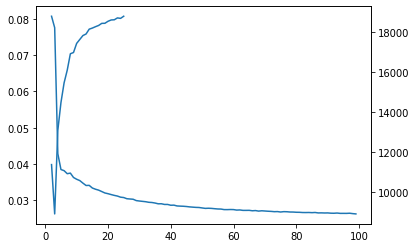

In [240]:
ycs, ccs = [], []
xs = range(2,100)
for b in xs:
    obs = bin_scan.observations[2.5][0]
    ee = ep.ErgodicEnsemble(obs, ep.binr(observations=obs, count=b))
    chi2 = ee.chi2()
    ccs.append(chi2[0])
    ycs.append(ee.complexity)
g = sns.lineplot(x=xs, y=ycs)
sns.lineplot(x=xs, y=ccs, ax=g.twinx())

# Chi2 relationship

# HALT AND CATCH FIRE












# Chi^2 Relationship

When Chi^2's is less than ~200 (i.e. the system is not complex) the relationship appears to be that C_e^2 has a linear relationship with Chi^2.

- The top left graph shows Chi^2 and C_e for varying different distributions. i.e. comparing observations from power 2.0 against 2.2, 2.3 etc.
- The top right shows the Chi^2 p-value for these same distributions.
- The middle left shows Chi^2 against C_e^2.
- While the bottom left shows Chi^2 against C_e and bottom right shows Chi^2 against C_e^2.

In [12]:
x = [2,3,4,5,6,7,8,9,10,15,20]

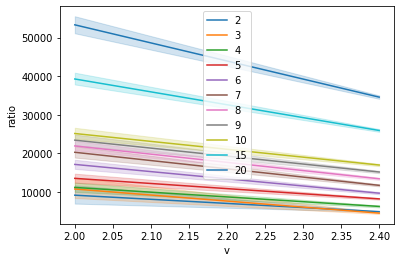

In [13]:
scans = []
for e in x:
    cs_power_26 = ChiScan(power, np.linspace(2,2.4,2), trials=100, obs=10000, ensembles=e, cp=nbsetup.cp)
    cs_power_26.ratios()
    scans.append(cs_power_26)

In [139]:
y = []
for s in scans:
    df = s.dataframe()
    means = df[df['v'] == 2.4].mean()
    y.append(means['chi^2']/means['ce'])

<AxesSubplot:>

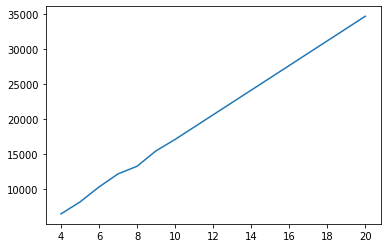

In [140]:
sns.lineplot(x=x[2:], y=y[2:])

In [158]:
m, c = regression(x=x[4:], y=y['ratio'][4:])

In [143]:
y = {'chi^2':[], 'ce':[], 'ratio':[]}
for s in scans:
    df = s.dataframe()
    means = df[df['v'] == 2.4].mean()
    y['chi^2'].append(means['chi^2'])
    y['ce'].append(means['ce'])
    y['ratio'].append(means['chi^2']/means['ce'])

<AxesSubplot:>

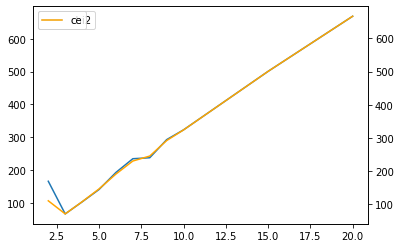

In [162]:
g = sns.lineplot(x=x, y=y['chi^2'], label='chi2')
npyce = np.array(y['ce'])
npx = np.array(x)
sns.lineplot(x=x, y=y['ce']*(m*npx+c), label='ce', ax=g.twinx(), color='orange')

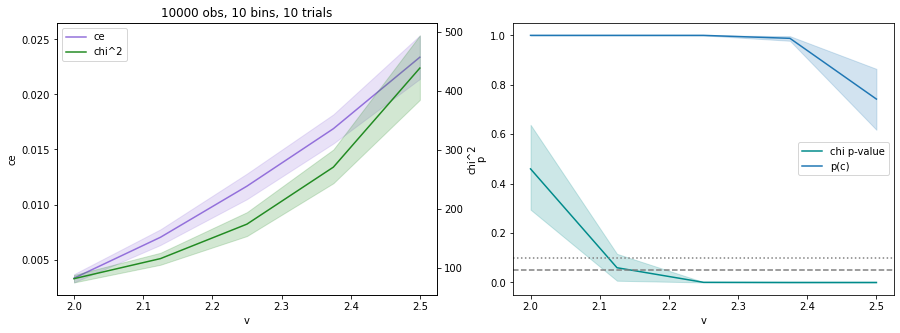

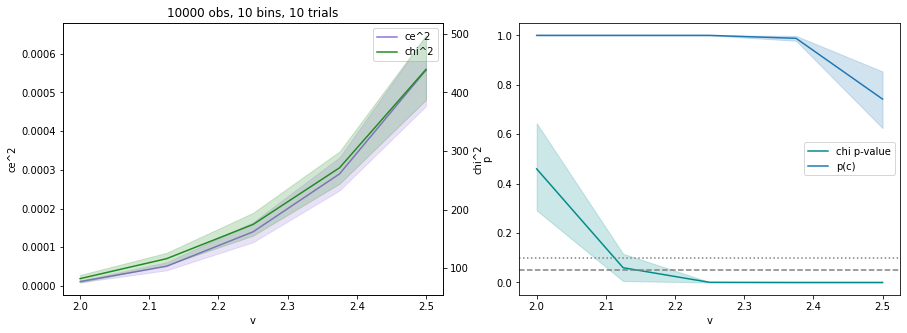

In [97]:
cs_power_26 = ChiScan(power, np.linspace(2,2.5,5), trials=10, obs=10000, ensembles=10, cp=nbsetup.cp)
cs_power_26.plot()
#cs_power_26.plot(y='cex')
cs_power_26.plot(y='ce^2')
#cs_power_26.correlate(2.0)

## Scaling

However, once the system becomes non-complex i.e. p < 0.05, the relationship then tends to become C_e is linear with Chi^2, with a constant regression. Now the bottom right graph is showing a C_e against C_e^2.

In [115]:
df

,ce,cex,ce^2,p,chi^2,obs,v,pcex
0,0.003840,14.132941,0.000015,5.010453e-01,35.313585,10000,2.0,0.999597
1,0.001915,8.621905,0.000004,9.623098e-01,22.436879,10000,2.0,0.999999
2,0.002657,10.745170,0.000007,8.499509e-01,27.337735,10000,2.0,0.999986
3,0.003577,13.380318,0.000013,5.377903e-01,34.545292,10000,2.0,0.999787
4,0.003267,12.492427,0.000011,5.295847e-01,34.716231,10000,2.0,0.999907
...,...,...,...,...,...,...,...,...
195,0.012430,38.718046,0.000155,7.986793e-04,68.838069,10000,2.4,0.347976
196,0.018876,57.168537,0.000356,8.964420e-20,172.730149,10000,2.4,0.013861
197,0.008394,27.166730,0.000070,1.753236e-04,74.387217,10000,2.4,0.855542
198,0.022950,68.827475,0.000527,2.068752e-25,204.328431,10000,2.4,0.000801


ValueError: Could not interpret value `pcex` for parameter `y`

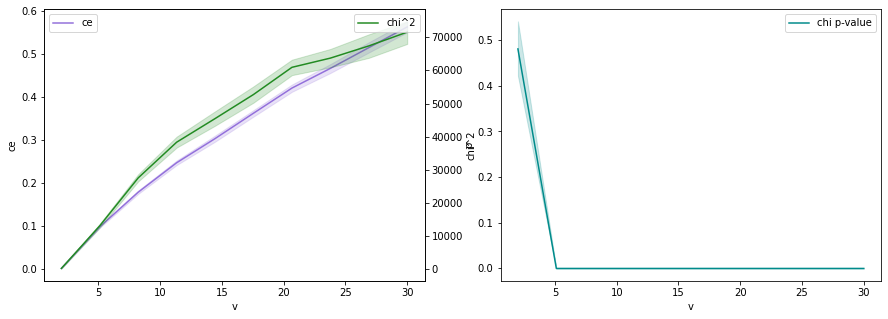

In [7]:
cs_power_220 = ChiScan(power, np.linspace(2,30,10), obs=10000, ensembles=20, cp=nbsetup.cp)
cs_power_220.plot()
cs_power_220.plot('ce^2')
cs_power_220.correlate(1.0)

The same is observed with distributions from other powers.

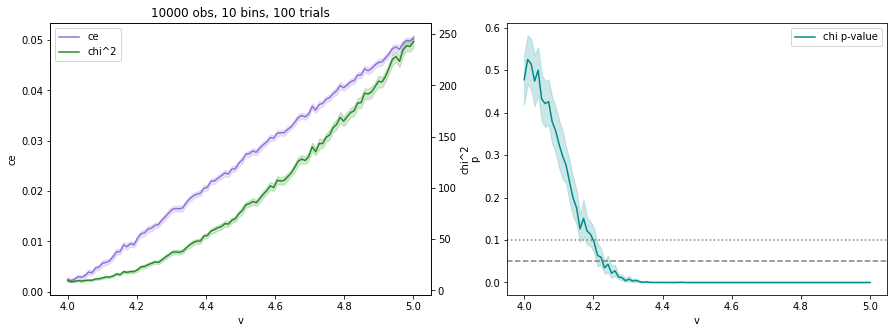

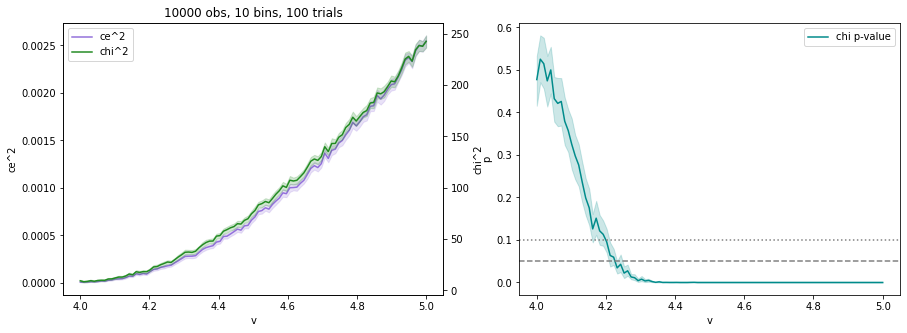

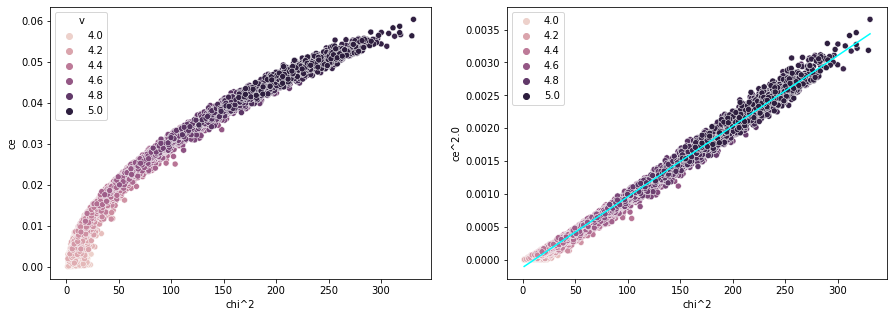

In [9]:
cs_power_46 = ChiScan(power, np.linspace(4,5,100), obs=10000, cp=nbsetup.cp)
cs_power_46.plot()
cs_power_46.plot('ce^2')
cs_power_46.correlate(2.0)

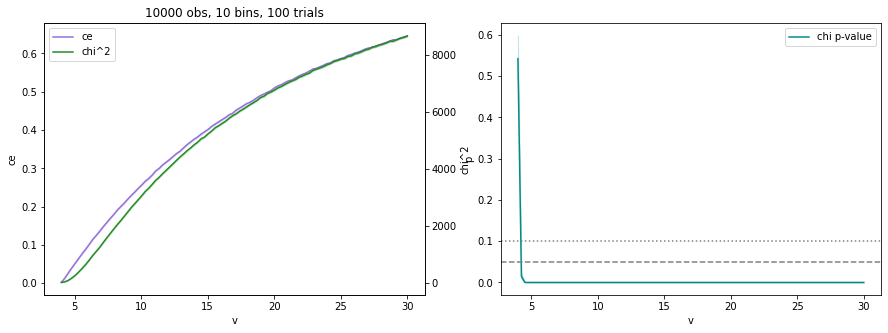

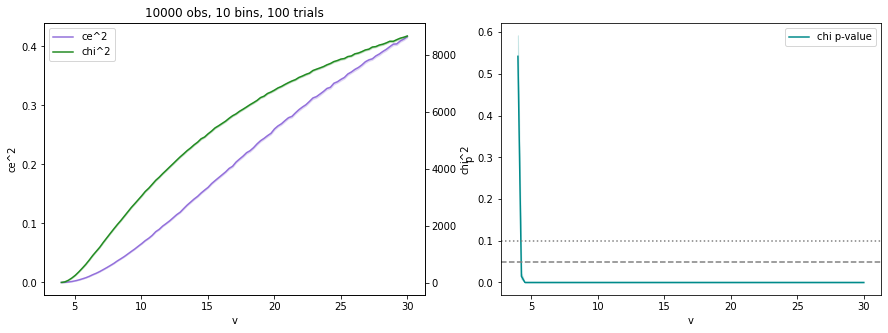

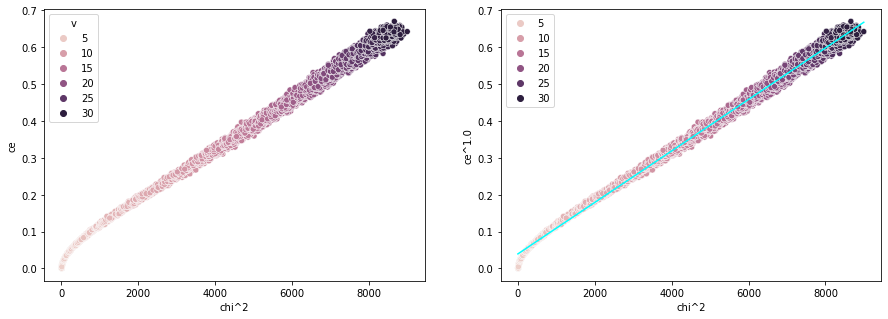

In [10]:
cs_power_46 = ChiScan(power, np.linspace(4,30,100), obs=10000, cp=nbsetup.cp)
cs_power_46.plot()
cs_power_46.plot('ce^2')
cs_power_46.correlate(1.0)

## Normal distribution

This same relationship for normal distributions isn't as evident.

In [212]:
normal05 = lambda i,f,v,o,s: np.random.normal(s(i, f, v),0.5,o)
normal005 = lambda i,f,v,o,s: np.random.normal(s(i, f, v),0.05,o)
#uniform = lambda i,f,v,o,s: np.random.uniform(f, v, o)

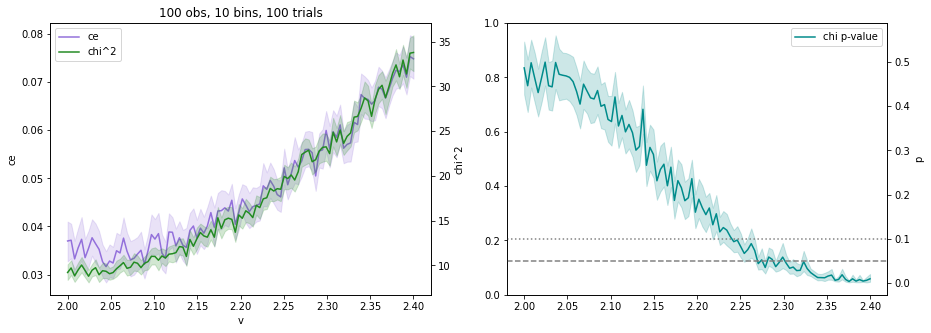

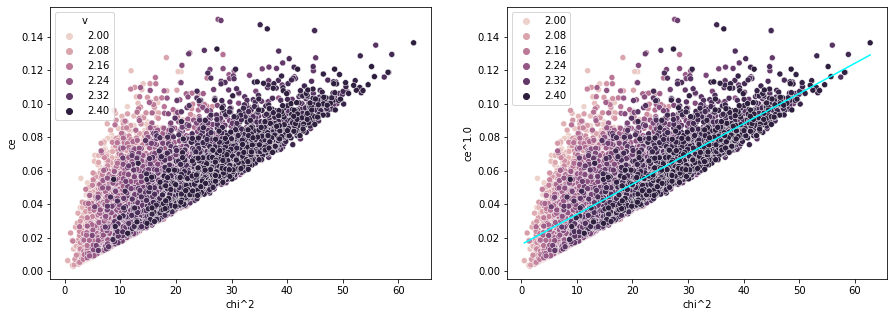

In [110]:
cs_normal = ChiScan(normal05, np.linspace(2,2.4,100), obs=100, cp=nbsetup.cp)
cs_normal.plot()
cs_normal.correlate(1.0)

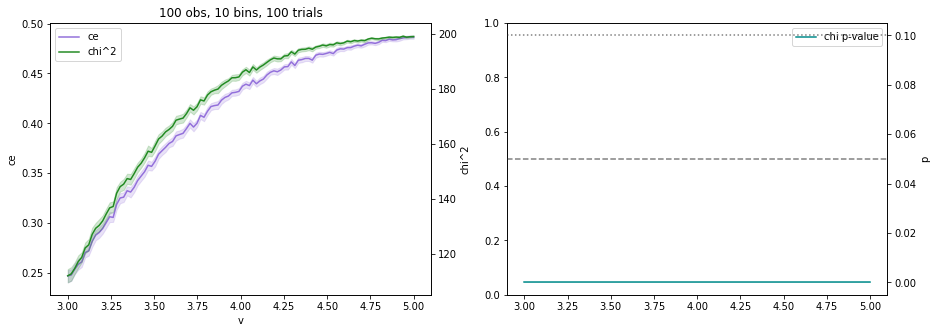

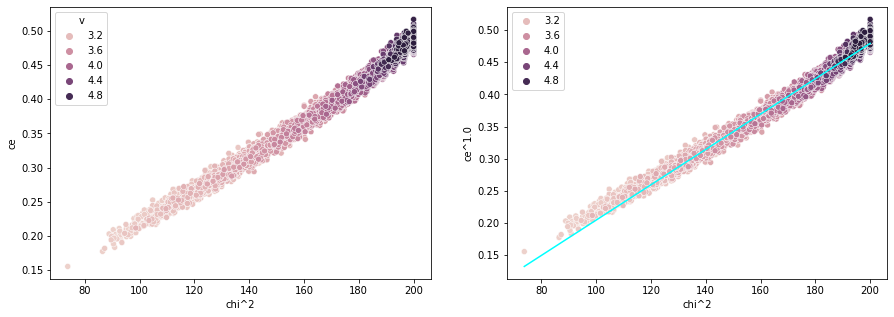

In [125]:
cs_normal = ChiScan(normal05, np.linspace(3,5,100), fixed=2, obs=100, cp=nbsetup.cp)
cs_normal.plot()
cs_normal.correlate(1.0)